In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import upscale_functions as uf
import re

In [2]:
file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/upscaling_layers.nc'
data = xr.open_dataset(file)
# Create an empty dataset with the same coordinates and dimensions
fluxes = xr.Dataset(coords=data.coords)
shape = (data.dims['y'], data.dims['x'])

In [3]:
# Loop through all 'ika_X_Y_Z' variables
for var_name in data.data_vars:
    match = re.match(r'ika_(\d)_(\d)_(\d)', var_name)
    if match:
        X, Y, Z = match.groups()

        # Parameter mapping
        Fert = 1 if Z == '1' else 2
        Habitat = 0 if Y == '1' else 1
        Plant = 0  # Adjust if needed

        # Compute fluxes
        GPP = uf.gpp_model(
            Age=data[var_name],
            model=4,
            T=data['air_temperature'],
            Vpd=data['vapor_pressure_deficit'],
            Fert=Fert,
            Habitat=Habitat
        )

        RECO = uf.reco_model(
            Age=data[var_name],
            model=3,
            T=data['air_temperature'],
            Plant=Plant,
            Fert=Fert
        )

        NEP_model = uf.nep_model(
            Age=data[var_name],
            model=3,
            T=data['air_temperature'],
            Plant=Plant,
            Fert=Fert
        )

        NEP_balance = GPP - RECO

        # Store in the fluxes dataset
        suffix = f"{X}_{Y}_{Z}"
        fluxes[f'GPP_{suffix}'] = GPP
        fluxes[f'RECO_{suffix}'] = RECO
        fluxes[f'NEP_{suffix}'] = NEP_model
        fluxes[f'BAL_{suffix}'] = NEP_balance

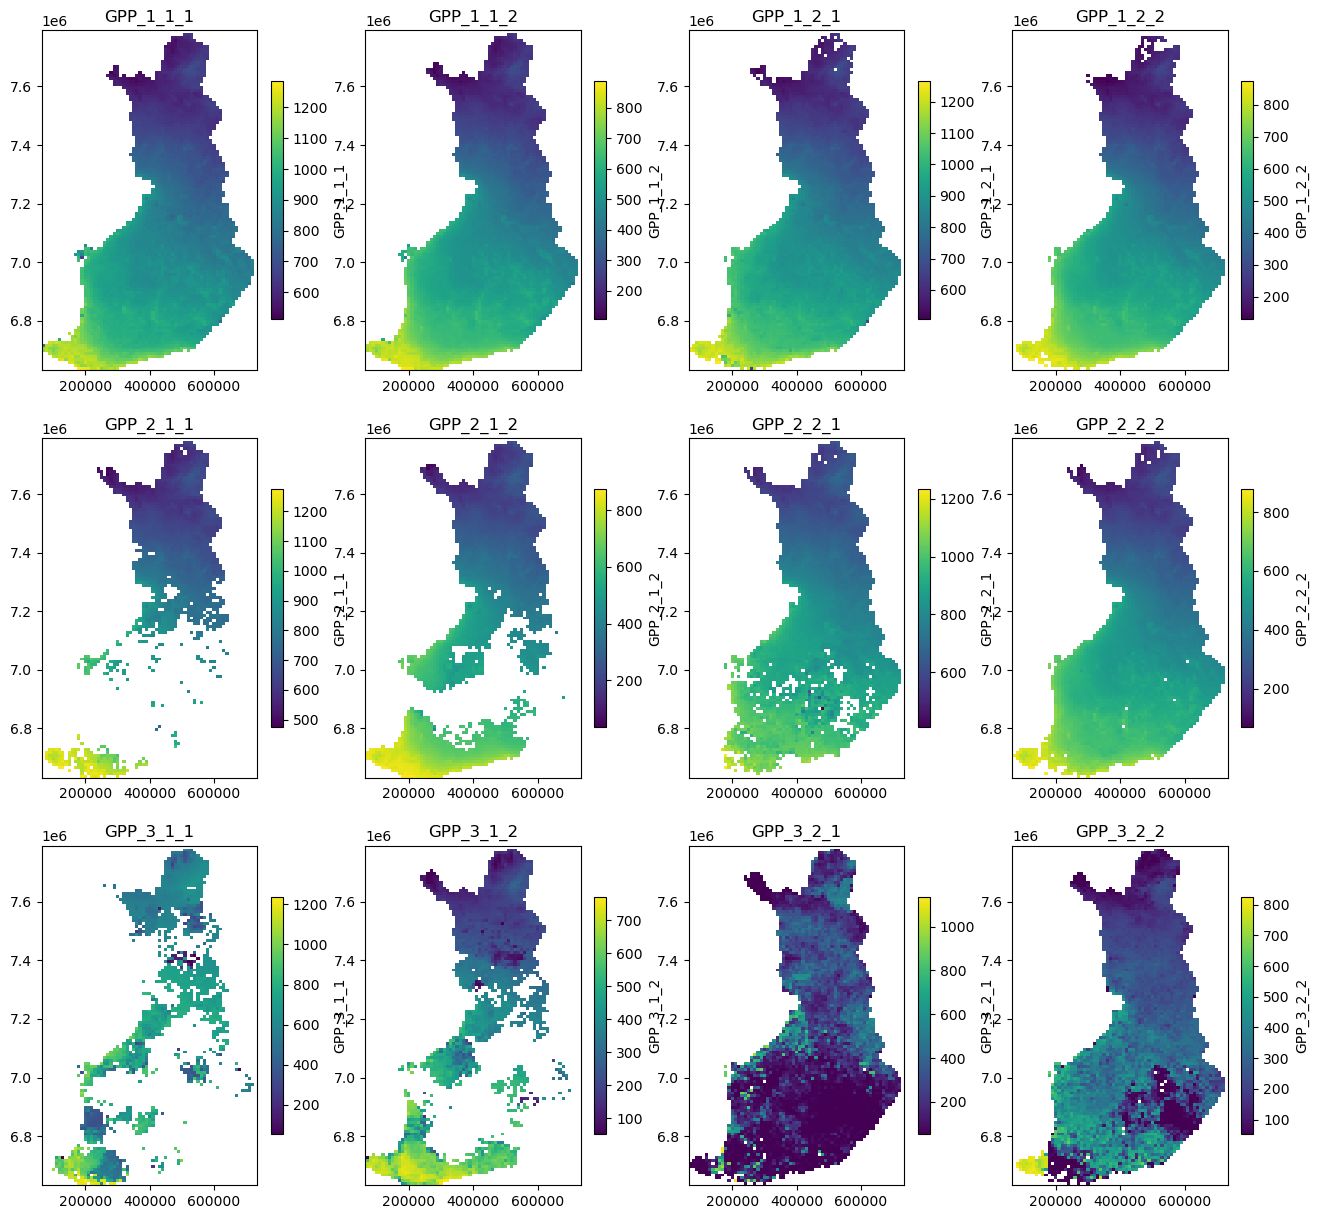

In [8]:
# Set keyword to filter variables
plot_only = 'GPP'  # or 'RECO', 'NEP', 'BAL', etc.
fig_file = f'/scratch/project_2000908/nousu/mNFI_to_NEP/figs_{plot_only}.png'

# Filter variables from fluxes that contain the keyword
selected_vars = [v for v in fluxes.data_vars if plot_only in v.upper()]

# Determine layout
n_vars = len(selected_vars)
n_cols = 4
n_rows = int(np.ceil(n_vars / n_cols))

# Create figure and axes
fig, axes = plt.subplots(n_rows, n_cols, figsize=(4 * n_cols, 5 * n_rows))
axes = axes.flatten()

# Plot each selected variable
for i, var in enumerate(selected_vars):
    fluxes[var].plot(ax=axes[i], cmap="viridis", cbar_kwargs={'shrink': 0.7})
    axes[i].set_title(var)
    axes[i].set_xlabel("")
    axes[i].set_ylabel("")

# Hide unused subplots
for j in range(n_vars, len(axes)):
    axes[j].axis("off")

# Save to file
fig_file = f'/scratch/project_2000908/nousu/mNFI_to_NEP/{plot_only}_plots.png'
plt.savefig(fig_file, dpi=300, bbox_inches='tight')

In [10]:
output_file = r'/scratch/project_2000908/nousu/mNFI_to_NEP/FINAL_LAYERS/carbon_fluxes.nc'
fluxes.to_netcdf(output_file)